# Box Atlas

In [1]:
#%load_ext autoreload
#%autoreload 2
#%pylab notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from copy import copy
from pympc.geometry.polytope import Polytope
from pympc.dynamical_systems import DTAffineSystem, DTPWASystem, dare
import pympc.plot as mpc_plt
from pympc.control import MPCHybridController

Acronyms:
q -> position, v -> velocity, f -> contact force
b -> body, lf -> left foot, rf -> right foot, h -> hand
x -> horizontal axis, y -> vertical axis

State vector \in R^10:
[q_b_x, q_b_y, q_lf_x, q_lf_y, q_rf_x, q_rf_y, q_h_x, q_h_y, v_b_x, v_b_y]

Input vector \in R^9:
[v_lf_x, v_lf_y, v_rf_x, v_rf_y, v_h_x, v_h_y, f_lf_x, f_rf_x, f_h_y]

In [3]:
# numeric constants

# scalar
mass = 1.
stiffness = 100.
gravity = 10.
friction_coefficient = .5
t_s = .1

# position bounds

# body
q_b_min = np.array([[0.],[0.]])
q_b_max = np.array([[1.],[1.]])
v_b_max = np.ones((2,1))
v_b_min = - v_b_max

# left foot (limits in the body frame)
q_lf_min = np.array([[0.],[-.7]])
q_lf_max = np.array([[.4],[-.3]])

# right foot (limits in the body frame)
q_rf_min = np.array([[-.4],[-.7]])
q_rf_max = np.array([[0.],[-.3]])

# hand (limits in the body frame)
q_h_min = np.array([[-.6],[-.1]])
q_h_max = np.array([[-.2],[.3]])

# velocity bounds

# body
v_b_max = np.ones((2,1))
v_b_min = - v_b_max

# left foot
v_lf_max = np.ones((2,1))
v_lf_min = - v_lf_max

# right foot
v_rf_max = np.ones((2,1))
v_rf_min = - v_rf_max

# hand
v_h_max = np.ones((2,1))
v_h_min = - v_rf_max

# force bounds

# left foot
f_lf_x_max = - friction_coefficient * stiffness * (q_b_min[1,0]+q_lf_min[1,0])
f_lf_x_min = - f_lf_x_max

# right foot
f_rf_x_max = - friction_coefficient * stiffness * (q_b_min[1,0]+q_rf_min[1,0])
f_rf_x_min = - f_rf_x_max

# hand
f_h_y_max = - friction_coefficient * stiffness * (q_b_min[0,0]+q_h_min[0,0])
f_h_y_min = - f_h_y_max

# equilibrium point
x_eq = np. array([
    [.5], # q_b_x
    [.5], # q_b_y
    [.7], # q_lf_x
    [-mass*gravity/2./stiffness], # q_lf_y
    [.3], # q_rf_x
    [-mass*gravity/2./stiffness], # q_rf_y
    [.2], # q_h_x
    [.6], # q_h_y
    [0.], # v_b_x
    [0.], # b_b_y
    ])
u_eq = np.zeros((9,1))

dynamics

In [4]:
def get_A(contact_set):
    contact_map_normal_force = {'lf':(9,3), 'rf':(9,5), 'h':(8,6)}
    A = np.vstack((
        np.hstack((np.zeros((2, 8)), np.eye(2))),
        np.zeros((8, 10))
        ))
    for contact in contact_set:
        A[contact_map_normal_force[contact]] = -stiffness/mass
    return A

def get_B(contact_set):
    contact_map_tangential_force = {'lf':(8,6), 'rf':(8,7), 'h':(9,8)}
    contact_map_tangential_velocity = {'lf':(2,0), 'rf':(4,2), 'h':(7,5)}
    B = np.vstack((
        np.zeros((2, 9)),
        np.hstack((np.eye(6), np.zeros((6, 3)))),
        np.zeros((2, 9))
        ))
    for contact in contact_set:
        B[contact_map_tangential_force[contact]] = 1./mass
    for contact in contact_set:
        B[contact_map_tangential_velocity[contact]] = 0.
    return B

c = np.vstack((np.zeros((9, 1)), np.array((-gravity))))


Kinematic limits

In [5]:
selection_matrix = np.vstack((np.eye(2), -np.eye(2)))

# left foot
lhs = np.hstack((-selection_matrix, selection_matrix, np.zeros((4,6))))
rhs = np.vstack((q_lf_max, -q_lf_min))
kinematic_limits = Polytope(lhs, rhs)

# right foot
lhs = np.hstack((-selection_matrix, np.zeros((4,2)), selection_matrix, np.zeros((4,4))))
rhs = np.vstack((q_rf_max, -q_rf_min))
kinematic_limits.add_facets(lhs, rhs)

# hand
lhs = np.hstack((-selection_matrix, np.zeros((4,4)), selection_matrix, np.zeros((4,2))))
rhs = np.vstack((q_h_max, -q_h_min))
kinematic_limits.add_facets(lhs, rhs)

# body
kinematic_limits.add_bounds(q_b_min, q_b_max, [0,1])
kinematic_limits.add_bounds(v_b_min, v_b_max, [8,9])

Input limits

In [6]:
input_max = np.vstack((v_lf_max, v_rf_max, v_h_max, f_lf_x_max, f_rf_x_max, f_h_y_max))
input_min = np.vstack((v_lf_min, v_rf_min, v_h_min, f_lf_x_min, f_rf_x_min, f_h_y_min))
input_limits = Polytope.from_bounds(input_min, input_max)

Mode indepenedent contraints

In [7]:
lhs = np.vstack((
    np.hstack((
        kinematic_limits.A,
        np.zeros((
            kinematic_limits.A.shape[0],
            input_limits.A.shape[1]
            ))
        )),
    np.hstack((
        np.zeros((
            input_limits.A.shape[0],
            kinematic_limits.A.shape[1]
            )),
        input_limits.A
        ))
    ))

rhs = np.vstack((kinematic_limits.b, input_limits.b))

mode_independent_constraints = Polytope(lhs, rhs)

Mode dependent constraints

In [8]:
def contact_constraints(domain, contact, active):
    contact_indices = {
    'lf': {'q': 3, 'f': 16},
    'rf': {'q': 5, 'f': 17},
    'h': {'q': 6, 'f': 18}
    }
    if active:
        domain.add_upper_bounds(np.array([[0.]]), [contact_indices[contact]['q']])
        lhs = np.zeros((2,19))
        lhs[0, contact_indices[contact]['f']] = 1.
        lhs[0, contact_indices[contact]['q']] = friction_coefficient * stiffness
        lhs[1, contact_indices[contact]['f']] = -1.
        lhs[1, contact_indices[contact]['q']] = friction_coefficient * stiffness
        rhs = np.zeros((2,1))
        domain.add_facets(lhs, rhs)
    else:
        domain.add_lower_bounds(np.array([[0.]]), [contact_indices[contact]['q']])
    return domain

contacts = ['lf', 'rf', 'h']
modes =  [mode for n_contacts in range(len(contacts)+1) for mode in combinations(contacts, n_contacts)]

domains = []
for mode in modes:
    domain = copy(mode_independent_constraints)
    for contact in contacts:
        domain = contact_constraints(domain, contact, contact in mode)
    domains.append(domain)

Translation to the equilibrium point

In [9]:
translated_affine_systems = [DTAffineSystem.from_continuous(get_A(mode), get_B(mode), c + get_A(mode).dot(x_eq), t_s, 'explicit_euler') for mode in modes]
translated_domains = []
for domain in domains:
    translated_domain = Polytope(domain.A, domain.b - domain.A.dot(np.vstack((x_eq, u_eq))))
    translated_domain.assemble()
    translated_domains.append(translated_domain)

PWA system

In [10]:
pwa_sys = DTPWASystem(translated_affine_systems, translated_domains)

In [11]:
# controller parameters
N = 10
Q = np.eye(10)
R = np.eye(9)
objective_norm = 'two'

# terminal set and cost
terminal_mode = 4
#P, K = dare(translated_affine_systems[terminal_mode].A, translated_affine_systems[terminal_mode].B, Q, R)
#X_N = ds.moas_closed_loop(translated_affine_systems[terminal_mode].A, translated_affine_systems[terminal_mode].B, K, X[1], U[1])
P = Q


X_N = Polytope.from_bounds(-np.ones((10,1))*.05, np.ones((10,1))*.05)
X_N.assemble()

# hybrid controller
controller = MPCHybridController(pwa_sys, N, objective_norm, Q, R, P, X_N)

We can now simulate the closed-loop dynamics starting from the initial state $x_0$.

In [12]:
N_sim = 100
x_0 = np.zeros((10,1))
x_0[0,0] = .1
u = []
x = [x_0]
#u_ws = None
#x_ws = None
#ss_ws = None
terminal_mode = 1
for k in range(N_sim):
    print k,
    #u_k, x_k, ss_k = controller.feedforward(x[k], u_ws, x_ws, ss_ws)[0:3]
    u_k, x_k, ss_k = controller.feedforward(x[k])[0:3]
    x_next = pwa_sys.simulate(x[k], [u_k[0]])[0][1]
    u.append(u_k[0])
    x.append(x_next)
    #u_ws = u_k[1:] + [K.dot(x_k[-1])]
    #x_ws = x_k[1:] + [pwa_sys.simulate(x_k[-1], [u_ws[-1]])[0][1]]
    #ss_ws = ss_k[1:] + (terminal_mode,)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


We can use the plot functions to visualize the time evolution of the system.

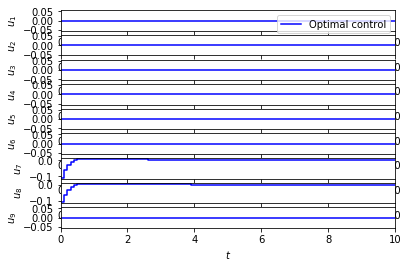

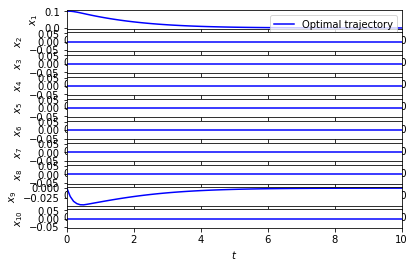

In [13]:
mpc_plt.input_sequence(u, t_s)
plt.show()
mpc_plt.state_trajectory(x, t_s)
plt.show()

In [14]:
import control
np.linalg.matrix_rank(control.ctrb(get_A(modes[terminal_mode]), get_B(modes[terminal_mode])))

9